# Titanic 

# Todo
 - Analyse Cabin and extract features
 - Read through variable notes (e.g. add is_age_estimated feature)
 - Tune prediction threshlod (kept at 0.5 default atm)
 - EDA in general
 - More intelligent imputation
 - Outliers

In [1]:
from pathlib import Path
import os

is_titanic_dir = str(Path(os.getcwd())).rsplit("\\")[-1] == "Titanic"

if is_titanic_dir:
    os.chdir("../")

In [2]:
%%capture

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier

from mlutils.model.baseline import AutoMLBaseline
from mlutils.preprocess.missing import check_missingness
from mlutils.visualise.features import feature_correlation_plot, plot_importances

### Load data

In [3]:
sns.set(rc={'figure.figsize':(10, 5)})

TARGET = "Survived"

DROP_COLS = [
    "PassengerId", 
    "Name",
    "Ticket", # remove this for now
    # "Cabin"
]

In [4]:
def load_raw_data(data_set="train", drop_cols=None):

    if data_set == "test":
        df = pd.read_csv("Titanic/Data/test.csv")
        drop_cols = [x for x in DROP_COLS if x != "PassengerId"]
    else:
        df = pd.read_csv("Titanic/Data/train.csv")

    if drop_cols is not None:
        df.drop(drop_cols, axis=1, inplace=True)

    return df

In [5]:
df = load_raw_data(data_set="train", drop_cols=DROP_COLS)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


### Cabin

The Cabin field consists of a single letter followed by a number.

It is assumed that the first letter indicates the area of the boat the cabin was in, and the number signifies room number within that area. The area of the boat the passenger was in could be informative of probability of survival.

In [6]:
df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Firstly extract the first letter and number. 

Then deal with missing data:
 - For the cabin_location: encode a field to indicate that it is missing as we cant reasonably impute
 - For the room number - impute with mean

In [7]:
def extract_cabin_features(df):
    # Create cabin location and number cols
    df["cabin_location"] = df["Cabin"].str.slice(0, 1)
    df["cabin_number"] = df["Cabin"].str.slice(1, 4).str.extract('(\d+)').astype(float)

    # Impute
    df["cabin_location"].fillna("M", inplace=True)
    df['cabin_number'] = df['cabin_number'].fillna(df["cabin_number"].mean())
    df.drop("Cabin", axis=1, inplace=True)

    return df
df = extract_cabin_features(df)

**Missing cabin data (cabin_location_M) seems to be most correlated with survival**

**Missingness**

In [8]:
check_missingness(df)

,pct_missing
Age,19.87
Embarked,0.22


In [9]:
def impute_data(df: pd.DataFrame) -> pd.DataFrame:
    # Impute embarked with mode for now
    mode_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df[['Embarked']] = mode_imputer.fit_transform(df[['Embarked']])

    # Impute age with median
    median_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    df["Age"] = median_imputer.fit_transform(df[["Age"]])

    return df
    
df = impute_data(df)

**Encode categorical variables**

In [10]:
def ohe(df):
    return pd.get_dummies(df, drop_first=True)
df = ohe(df)

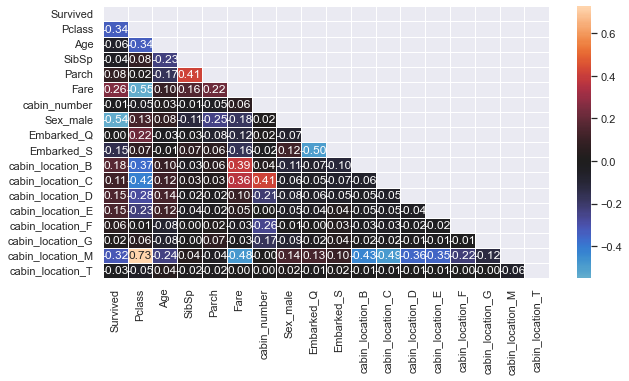

In [11]:
feature_correlation_plot(df)

**Class imbalance**

In [12]:
pct_positive = len(df.loc[df[TARGET] == 1]) / len(df) * 100
pct_positive

38.38383838383838

**X, y**

In [13]:
X, y = df.drop(TARGET, axis=1), df[TARGET]

### Basline model

In [14]:
%%capture
baseline_performance = AutoMLBaseline(X, y, scoring="accuracy", n_cv=3).run_experiment()

In [15]:
baseline_performance

,score
XGBClassifier,0.814815
LogisticRegression,0.792368
RandomForestClassifier,0.792368
MLPClassifier,0.775533
GaussianNB,0.720539
SVC,0.667789
DummyClassifier,0.616162


### XGBoost

Tune xgboost model

In [16]:
%%capture

xgb = XGBClassifier(scale_pos_weight = (100 - pct_positive) / pct_positive)

params = {
    "max_depth": [6, 9, 12, 15],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "colsample_bytree": [0.3, 0.5, 0.75]
}

stratified_kfold = StratifiedKFold(n_splits=3)

clf = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='accuracy', 
                   verbose=1,
                   n_jobs=-1,
                   cv=stratified_kfold)

clf.fit(X, y)
xgb_tuned = clf.best_estimator_

Best score 0.824
Best params {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000}


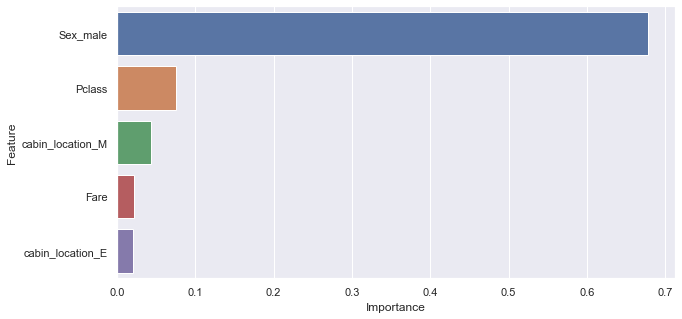

In [17]:
print(f"Best score {round(clf.best_score_, 3)}")
print(f"Best params {clf.best_params_}")

plot_importances(clf.best_estimator_, X.columns, 5)

### Score test set and submit

In [38]:
df_test = load_raw_data("test", DROP_COLS)
df_test = extract_cabin_features(df_test)
df_test = impute_data(df_test)
df_test = ohe(df_test)

# Add in additional features if groups missing from test set 
missing_features = list(
    set(X) -
    set(df_test.drop("PassengerId", axis=1).columns)
)
print(f"Adding missing features to test set: {missing_features}")

for missing_feature in missing_features:
    df_test[missing_feature] = 0

Adding missing features to test set: ['cabin_location_T']


In [39]:
%%capture
y_hats = df_test[["PassengerId"]]
y_hats["Survived"] = xgb_tuned.predict(df_test.drop("PassengerId", axis=1))
y_hats.to_csv("Titanic/Data/test_predictions.csv", index=False)